In [138]:
import networkx as nx
from lxml import etree
import itertools
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline

# Social Network Analysis: NetworkX

Let's take a look at a single play. Luckily, there are databases that exists that have already annotated a lot of the text in a markup language called XML. Especially well researched corpora have extensive metadata. We'll look at the Shakespeare corpus with data obtained from https://www.playshakespeare.com/ .

We'll start by looking at *Othello*.

In [114]:
with open("othello_ps_v3.xml") as f:
    othello_xml = etree.fromstring(f.read().encode())

We can get all elements of the XML tree by iterating over all the nodes:

In [115]:
all_elements = list(othello_xml.iter())
all_elements

[<Element play at 0x111b4da88>,
 <Element title at 0x10dc7da48>,
 <Element playwright at 0x10dc7d588>,
 <Element act at 0x10dc7de48>,
 <Element acttitle at 0x10dc7dc48>,
 <Element scene at 0x111bc50c8>,
 <Element scenetitle at 0x111bc5dc8>,
 <Element scenelocation at 0x111bc5948>,
 <Element scenepersonae at 0x111bc5088>,
 <Element stagedir at 0x111bc5e48>,
 <Element speech at 0x10d33df08>,
 <Element speaker at 0x111bd7d48>,
 <Element line at 0x111bd7ec8>,
 <Element line at 0x111733048>,
 <Element line at 0x1116fa8c8>,
 <Element speech at 0x1116fa308>,
 <Element speaker at 0x10d784b88>,
 <Element line at 0x10d48ce08>,
 <Element line at 0x111788288>,
 <Element line at 0x10dce5308>,
 <Element speech at 0x10dce5508>,
 <Element speaker at 0x10dce5048>,
 <Element line at 0x10dce53c8>,
 <Element speech at 0x10dce5148>,
 <Element speaker at 0x10d475708>,
 <Element line at 0x10d475e48>,
 <Element line at 0x10d475e88>,
 <Element line at 0x111ba4088>,
 <Element line at 0x111ba4208>,
 <Element lin

That's a lot of information! Let's grab out all of the speakers. All the `speaker` elements will have a `text` attribute. To get a unique list we'll use `set`:

In [116]:
set([e.text for e in all_elements if e.tag == "speaker"])

{'1. GENT.',
 '1. MESS.',
 '1. MUS.',
 '1. SEN.',
 '2. GENT.',
 '2. MESS.',
 '2. SEN.',
 '3. GENT.',
 'ALL.',
 'BIAN.',
 'BRA.',
 'CAS.',
 'CLO.',
 'DES.',
 'DUKE',
 'DUKE.',
 'EMIL.',
 'GENTLEMEN.',
 'GRA.',
 'HER.',
 'IAGO',
 'IAGO.',
 'LOD.',
 'MON.',
 'OFF.',
 'OTH.',
 'ROD.',
 'SAIL.'}

Great start! In Network Analysis there are two fundamental principles. A ***node*** is an entity, it can have relationships with other entities. In literature, this is often a character, but it could be a Twitter user, organization, geographic location, or even words!

We may be interested in a node's properties. If it's a character, we may want to know how often they speak, age, etc. We can add this to the network as further layers.

The second concept is an ***edge***. An edge connects nodes. We're foremost interested in the volume of connections between nodes. For literature, this would be the number of times two characters interact.

As we learned from Moretti and our readings for today, this is a very difficult task for most texts. Where does on character's speech end and another's begin? Luckily, in plays this is slightly easier to identify (though still not perfectly clear).

For Shakespeare, we'll settle for them being present in the same *scene*. If they're in the same scene together, we'll increase our measure of their interaction.

Thus for each character we want to know how many lines the speak in the entire play, along with which scenes they appear in. We can then collate this wil the other characters.

The `get_cast_dict` function below will parse the XML data and extrac this information.

In [117]:
def get_cast_dict(all_elements):
    '''
    returns a dictionary with the total number of lines and scenes a character appears in
    '''
    
    cast_dict = {}
    
    # first get a unique set of all characters appearing in the play
    for c in set([e.text for e in all_elements if e.tag == "speaker"]):
        cast_dict[c] = {"num_lines": 0,
                        "scenes": []}
    
    # extract all scene elements from the xml
    scenes = [e for e in all_elements if e.tag == "scene"]
    
    # iterate through each scene
    for sc in scenes:
        
        # grab all the speeches in the scene
        speeches = [s for s in sc.getchildren() if s.tag == "speech"]
        
        # iterate through speeches
        for s in speeches:
            
            # increment number of lines for the speaker
            cast_dict[s.find("speaker").text]["num_lines"] += len(s.findall("line"))
            
        # find all the speaker for each speech    
        speakers = [s.find("speaker").text for s in speeches]
        
        # add the title of the scene for each speaker appearing in the scene
        for s in set(speakers):
            cast_dict[s]["scenes"].append(sc.find("scenetitle").text)
        
    # reassign scenes to only a unique set
    for c in cast_dict.keys():
        cast_dict[c]["scenes"] = list(set(cast_dict[c]["scenes"]))
            
    return cast_dict

In [118]:
cast_dict = get_data(all_elements)
cast_dict

{'1. GENT.': {'num_lines': 3, 'scenes': ['Scene 1']},
 '1. MESS.': {'num_lines': 9, 'scenes': ['Scene 3']},
 '1. MUS.': {'num_lines': 5, 'scenes': ['Scene 1']},
 '1. SEN.': {'num_lines': 26, 'scenes': ['Scene 3']},
 '2. GENT.': {'num_lines': 14, 'scenes': ['Scene 1']},
 '2. MESS.': {'num_lines': 2, 'scenes': ['Scene 1']},
 '2. SEN.': {'num_lines': 5, 'scenes': ['Scene 3']},
 '3. GENT.': {'num_lines': 17, 'scenes': ['Scene 1']},
 'ALL.': {'num_lines': 4, 'scenes': ['Scene 2', 'Scene 3']},
 'BIAN.': {'num_lines': 26, 'scenes': ['Scene 4', 'Scene 1']},
 'BRA.': {'num_lines': 139, 'scenes': ['Scene 1', 'Scene 2', 'Scene 3']},
 'CAS.': {'num_lines': 224,
  'scenes': ['Scene 1', 'Scene 2', 'Scene 3', 'Scene 4']},
 'CLO.': {'num_lines': 14, 'scenes': ['Scene 1', 'Scene 4']},
 'DES.': {'num_lines': 353,
  'scenes': ['Scene 1', 'Scene 2', 'Scene 3', 'Scene 4']},
 'DUKE': {'num_lines': 1, 'scenes': ['Scene 3']},
 'DUKE.': {'num_lines': 64, 'scenes': ['Scene 3']},
 'EMIL.': {'num_lines': 228,
  '

That's all we need to make a basic network and do some analysis! The `NetworkX` Python library will parse this dictionary for us to make a graph object. Let's write a function:

In [145]:
def make_graph(c_dict):
    '''
    This function accepts a dictionary with number of lines and scenes to create a
    NetworkX graph object
    '''
    # setup graph object
    G = nx.Graph()
    
    # add nodes with attributes of number of lines and scenes
    for c in c_dict.keys():
        if c_dict[c]["num_lines"] > 0:
            G.add_node(
                c,
                number_of_lines=c_dict[c]["num_lines"],
                scenes=c_dict[c]["scenes"]
            )

    # make edges by iterating over all combinations of nodes
    for (node1, data1), (node2, data2) in itertools.combinations(G.nodes(data=True), 2):

        # count scenes together by getting union of their sets
        scenes_together = len(set(data1['scenes']) & set(data2['scenes']))
        
        if scenes_together:
            # add more weight for more scenes together
            G.add_edge(node1, node2, weight=scenes_together)
            
    return G

In [146]:
G = make_graph(cast_dict)

We can graph this using `matplotlib`:

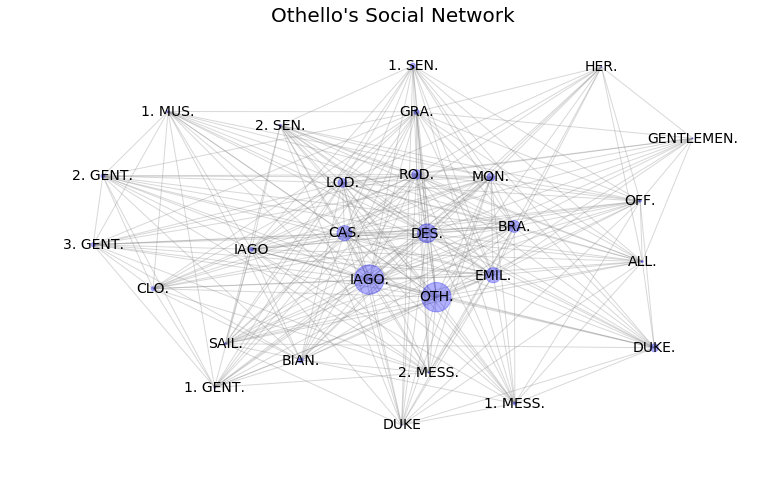

In [147]:
# nodes should be sized by number of lines
node_size = [data['number_of_lines'] for __, data in G.nodes(data=True)]

# Nodes should be colored by gender.
# node_color = ['blue' if data['gender'] == 'male' else 'red' for __, data in G.nodes(data=True)]
node_color = 'blue'

plt.figure(figsize=(13,8))  # make the figure size a little larger
plt.axis('off')  # remove the axis, which isn't meaningful in this case
plt.title("Othello's Social Network", fontsize=20)

# The 'k' argument determines how spaced out the nodes will be from
# one another on the graph.
pos = nx.spring_layout(G, k=0.5)

nx.draw_networkx(
    G,
    pos=pos,
    node_size=node_size,
    node_color=node_color,
    edge_color='gray',  # change edge color
    alpha=0.3,  # make nodes more transparent to make labels clearer
    font_size=14,
)

Our graph, `G`, is a powerful object. We can calculate many of the standard network analysis statistics. There are various measures of centrality, many of which were referenced in the reading.

In [155]:
network_tab = Table()
network_tab.append_column(label="Characters", values=[c for c in sorted(cast_dict.keys())])
network_tab.show()

Characters
1. GENT.
1. MESS.
1. MUS.
1. SEN.
2. GENT.
2. MESS.
2. SEN.
3. GENT.
ALL.
BIAN.


In [156]:
# "degree centrality" is a basic normalized measure of how many edges connect to a node
dc = [x[1] for x in sorted(nx.degree_centrality(G).items(), key=lambda x: x[0])]
network_tab.append_column(label="Degree Centrality", values=dc)
network_tab.show()

Characters,Degree Centrality
1. GENT.,0.62963
1. MESS.,0.62963
1. MUS.,0.62963
1. SEN.,0.62963
2. GENT.,0.62963
2. MESS.,0.62963
2. SEN.,0.62963
3. GENT.,0.62963
ALL.,0.740741
BIAN.,0.62963


Eigenvector centrality is the...

In [157]:
ec = [x[1] for x in sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[0])]
network_tab.append_column(label="Eigenvector Centrality", values=ec)
network_tab.show()

Characters,Degree Centrality,Eigenvector Centrality
1. GENT.,0.62963,0.0956106
1. MESS.,0.62963,0.0954374
1. MUS.,0.62963,0.0956106
1. SEN.,0.62963,0.0954374
2. GENT.,0.62963,0.0956106
2. MESS.,0.62963,0.0956106
2. SEN.,0.62963,0.0954374
3. GENT.,0.62963,0.0956106
ALL.,0.740741,0.175464
BIAN.,0.62963,0.138249


Betweeness is the centrality...

In [158]:
bc = [x[1] for x in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[0])]
network_tab.append_column(label="Betweenness Centrality", values=bc)
network_tab.show()

Characters,Degree Centrality,Eigenvector Centrality,Betweenness Centrality
1. GENT.,0.62963,0.0956106,0
1. MESS.,0.62963,0.0954374,0
1. MUS.,0.62963,0.0956106,0
1. SEN.,0.62963,0.0954374,0
2. GENT.,0.62963,0.0956106,0
2. MESS.,0.62963,0.0956106,0
2. SEN.,0.62963,0.0954374,0
3. GENT.,0.62963,0.0956106,0
ALL.,0.740741,0.175464,0.00500734
BIAN.,0.62963,0.138249,0


Much of this code is adapted from http://www.adampalay.com/blog/2015/04/17/shakespeare-social-networks/ .

# Challenge

What is the overlap (rank correlation) between the three measurements presented above? What does that mean for the play?

# Bonus: Making a prettier graph

# Homework

I've downloaded N more Shakespeare plays in the exact same XML structure. Write some code to loop through them all and produce a graph.

Print the most central character in each play according to Eigenvector Centrality: